In [1]:
#import decision regression tools:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text
import plotly.express as px
import config

In [2]:
# create database engine
db_url = f"postgresql://{config.DB_USERNAME}:{config.DB_PASSWORD}@{config.DB_HOST}/{config.DB_NAME}"
engine = create_engine(db_url)

/Users/ericdally/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
# load all the data into a datafame by joining the tables
query = text('''
Select * 
FROM "RawRecords" as r
JOIN "CalculatedStats" AS cs ON cs."RecordId"=r."Id";
''')
df = pd.read_sql_query(query,con=engine)
df.set_index('Id', inplace=True)
df

,State,Year,Enrolled,TotalRevenue,FederalRevenue,StateRevenue,LocalRevenue,TotalExpenditure,InstructionExpenditure,SupportServicesExpenditure,...,AvgMath4Score,AvgMath8Score,AvgReading4Score,AvgReading8Score,RecordId,FederalFundingPercent,StateFundingPercent,LocalFundingPercent,RevenuePerStudent,InstructionalExpensePercent
Id,,,,,,,,,,,,,,,,,,,,,
2003_ALABAMA,ALABAMA,2003,727900.0,5196054.0,567704.0,2966981.0,1661369.0,5298932.0,2817111.0,1521462.0,...,223.0,262.0,207.0,253.0,2003_ALABAMA,0.109257,0.571007,0.319737,7.138417,0.542164
2003_ALASKA,ALASKA,2003,133303.0,1425948.0,259423.0,813371.0,353154.0,1610289.0,763525.0,514052.0,...,233.0,279.0,212.0,256.0,2003_ALASKA,0.181930,0.570407,0.247663,10.697044,0.535451
2003_ARIZONA,ARIZONA,2003,875111.0,6529894.0,740579.0,2912629.0,2876686.0,6210287.0,2810907.0,1964229.0,...,229.0,271.0,209.0,255.0,2003_ARIZONA,0.113414,0.446045,0.440541,7.461789,0.430467
2003_ARKANSAS,ARKANSAS,2003,450158.0,3241275.0,379947.0,2394336.0,466992.0,3242799.0,1768713.0,972598.0,...,229.0,266.0,214.0,258.0,2003_ARKANSAS,0.117221,0.738702,0.144077,7.200305,0.545684
2003_CALIFORNIA,CALIFORNIA,2003,6226552.0,59815855.0,5795655.0,33617766.0,20402434.0,59749885.0,29561563.0,17030335.0,...,227.0,267.0,206.0,251.0,2003_CALIFORNIA,0.096892,0.562021,0.341087,9.606578,0.494209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015_VIRGINIA,VIRGINIA,2015,1279867.0,15857524.0,1012205.0,6240349.0,8604970.0,16113212.0,8755896.0,5075509.0,...,247.0,288.0,229.0,267.0,2015_VIRGINIA,0.063831,0.393526,0.542643,12.389978,0.552160
2015_WASHINGTON,WASHINGTON,2015,1072359.0,13709442.0,1036422.0,8293812.0,4379208.0,13630138.0,6508964.0,4510672.0,...,245.0,287.0,226.0,267.0,2015_WASHINGTON,0.075599,0.604971,0.319430,12.784377,0.474780
2015_WEST_VIRGINIA,WEST_VIRGINIA,2015,279565.0,3478401.0,362959.0,1979466.0,1135976.0,3466981.0,1819903.0,1161944.0,...,235.0,271.0,216.0,260.0,2015_WEST_VIRGINIA,0.104347,0.569074,0.326580,12.442191,0.523201


## Tweaking Database

In [4]:
model_df = df[[
    "AvgMath4Score",
    "AvgMath8Score",
    "AvgReading4Score",
    "AvgReading8Score",
    "FederalFundingPercent",
    "StateFundingPercent",
    "LocalFundingPercent",
    "RevenuePerStudent",
    "InstructionalExpensePercent"
]]
model_df.index = df.index
model_df

,AvgMath4Score,AvgMath8Score,AvgReading4Score,AvgReading8Score,FederalFundingPercent,StateFundingPercent,LocalFundingPercent,RevenuePerStudent,InstructionalExpensePercent
Id,,,,,,,,,
2003_ALABAMA,223.0,262.0,207.0,253.0,0.109257,0.571007,0.319737,7.138417,0.542164
2003_ALASKA,233.0,279.0,212.0,256.0,0.181930,0.570407,0.247663,10.697044,0.535451
2003_ARIZONA,229.0,271.0,209.0,255.0,0.113414,0.446045,0.440541,7.461789,0.430467
2003_ARKANSAS,229.0,266.0,214.0,258.0,0.117221,0.738702,0.144077,7.200305,0.545684
2003_CALIFORNIA,227.0,267.0,206.0,251.0,0.096892,0.562021,0.341087,9.606578,0.494209
...,...,...,...,...,...,...,...,...,...
2015_VIRGINIA,247.0,288.0,229.0,267.0,0.063831,0.393526,0.542643,12.389978,0.552160
2015_WASHINGTON,245.0,287.0,226.0,267.0,0.075599,0.604971,0.319430,12.784377,0.474780
2015_WEST_VIRGINIA,235.0,271.0,216.0,260.0,0.104347,0.569074,0.326580,12.442191,0.523201


In [5]:
#dropping DISTRICT_OF_COLUMBIA data
df = df.loc[df['State'] != 'DISTRICT_OF_COLUMBIA']
df.shape

(350, 22)

In [6]:
# combining grade scores
Avg_Score = (df.AvgMath4Score + df.AvgMath8Score + df.AvgReading4Score + df.AvgReading8Score)/4
df['Avg Score'] = Avg_Score
df.head()

/Users/ericdally/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,State,Year,Enrolled,TotalRevenue,FederalRevenue,StateRevenue,LocalRevenue,TotalExpenditure,InstructionExpenditure,SupportServicesExpenditure,...,AvgMath8Score,AvgReading4Score,AvgReading8Score,RecordId,FederalFundingPercent,StateFundingPercent,LocalFundingPercent,RevenuePerStudent,InstructionalExpensePercent,Avg Score
Id,,,,,,,,,,,,,,,,,,,,,
2003_ALABAMA,ALABAMA,2003,727900.0,5196054.0,567704.0,2966981.0,1661369.0,5298932.0,2817111.0,1521462.0,...,262.0,207.0,253.0,2003_ALABAMA,0.109257,0.571007,0.319737,7.138417,0.542164,236.25
2003_ALASKA,ALASKA,2003,133303.0,1425948.0,259423.0,813371.0,353154.0,1610289.0,763525.0,514052.0,...,279.0,212.0,256.0,2003_ALASKA,0.181930,0.570407,0.247663,10.697044,0.535451,245.00
2003_ARIZONA,ARIZONA,2003,875111.0,6529894.0,740579.0,2912629.0,2876686.0,6210287.0,2810907.0,1964229.0,...,271.0,209.0,255.0,2003_ARIZONA,0.113414,0.446045,0.440541,7.461789,0.430467,241.00
2003_ARKANSAS,ARKANSAS,2003,450158.0,3241275.0,379947.0,2394336.0,466992.0,3242799.0,1768713.0,972598.0,...,266.0,214.0,258.0,2003_ARKANSAS,0.117221,0.738702,0.144077,7.200305,0.545684,241.75
2003_CALIFORNIA,CALIFORNIA,2003,6226552.0,59815855.0,5795655.0,33617766.0,20402434.0,59749885.0,29561563.0,17030335.0,...,267.0,206.0,251.0,2003_CALIFORNIA,0.096892,0.562021,0.341087,9.606578,0.494209,237.75


# Linear Regression for Local Funding

In [7]:
# Defining variables
X = df[["LocalFundingPercent"]]
y = df['Avg Score']

In [8]:
#Creating regression object
regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression()

In [9]:
#Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [10]:
y_prediction =  regr.predict(X_test)

In [11]:
#Comparing the Test Set with Predicted Values
df_L = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_prediction})
df_L.head()

,Real Values,Predicted Values
Id,,
2009_IOWA,253.25,252.732541
2007_SOUTH_CAROLINA,247.50,252.458308
2013_NORTH_CAROLINA,254.50,248.280511
2015_MICHIGAN,248.50,250.428591
2011_PENNSYLVANIA,256.75,254.234721


In [12]:
#Evaluating Regression Model
from sklearn.metrics import mean_squared_error, r2_score

r2 = r2_score(y_test, y_prediction)
mse = mean_squared_error(y_test, y_prediction)

print(f'R2 Value is {r2}, Means Squared Error is {mse}')

R2 Value is 0.20932042871246492, Means Squared Error is 36.66394282818498


In [13]:
#Finding slope and intercept
print(regr.coef_)
print(regr.intercept_)

[19.80039247]
243.2134624767756


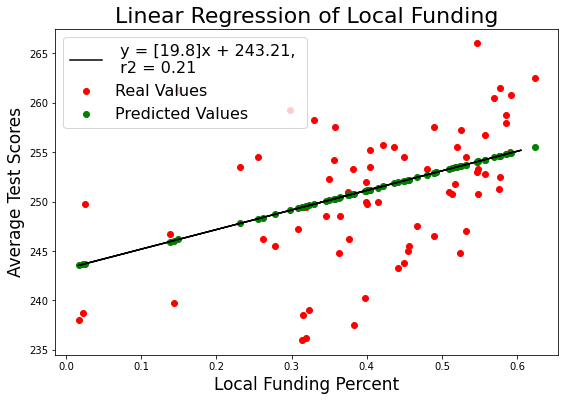

In [14]:
# plotting the results
m = np.round(regr.coef_,2)
b = np.round(regr.intercept_,2)
line = f' y = {m}x + {b}'
r2 = np.round(r2,2)

plt.figure(figsize=(9,6))
plt.scatter(X_test, y_test, color = 'red', label = 'Real Values')
plt.scatter(X_test, y_prediction, color = 'green', label = 'Predicted Values')
plt.plot(X_train, regr.predict(X_train), color = 'black',
         label= f'{line}, \n r2 = {r2}')


plt.title('Linear Regression of Local Funding', fontsize=22)
plt.xlabel('Local Funding Percent', fontsize=17)
plt.ylabel('Average Test Scores', fontsize=17)
plt.legend(fontsize=16)
plt.show()


### What happens if we increase local spending by 10%

In [15]:
#Function of Linear reqression is y = 19.8002955743824*x + 243.21350329342064
#f(0.2) = 247.17356240829712
#f(0.3) = 249.15359196573536
#Increase = 1.98002955743824

#If you increase local funding by 10 percent, NAEP test scores will go up about 2 grade points 

# Linear Regression for Revenue Per Student

In [16]:
# Defining variables
X1 = df[["RevenuePerStudent"]]
y1 = df['Avg Score']

In [17]:
#Creating regression object
regr1 = linear_model.LinearRegression()
regr1.fit(X1, y1)

LinearRegression()

In [18]:
#Splitting the dataset into the Training set and Test set
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2)

In [19]:
#Make Prediction
y1_prediction =  regr1.predict(X1_test)

In [20]:
#Comparing the Test Set with Predicted Values
df_R = pd.DataFrame({'Real Values':y1_test, 'Predicted Values':y1_prediction})
df_R.head()

,Real Values,Predicted Values
Id,,
2015_IDAHO,253.50,247.950508
2005_KENTUCKY,247.25,248.087319
2013_MASSACHUSETTS,265.75,255.994486
2013_ARIZONA,248.25,248.588904
2005_MARYLAND,249.25,250.917016


In [21]:
#Evaluating Regression Model
from sklearn.metrics import mean_squared_error, r2_score

r21 = r2_score(y1_test, y1_prediction)
mse1 = mean_squared_error(y1_test, y1_prediction)

print(f'R2 Value is {r21}, Means Squared Error is {mse1}')

R2 Value is 0.2674219323821081, Means Squared Error is 30.27891855960431


In [22]:
#Finding slope and intercept
print(regr1.coef_)
print(regr1.intercept_)

[0.83886236]
241.31635940851083


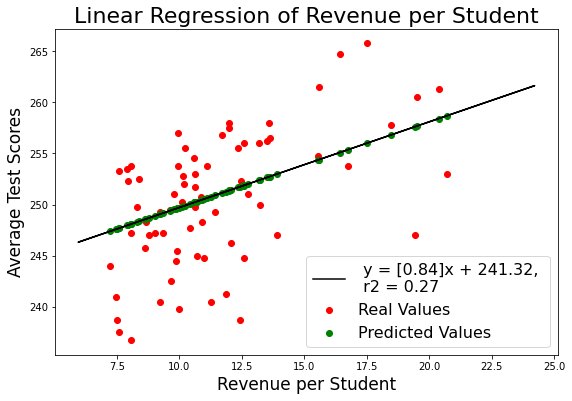

In [23]:
# plotting the results
m = np.round(regr1.coef_,2)
b = np.round(regr1.intercept_,2)
line = f' y = {m}x + {b}'
r2 = np.round(r21,2)

plt.figure(figsize=(9,6))
plt.scatter(X1_test, y1_test, color = 'red', label = 'Real Values')
plt.scatter(X1_test, y1_prediction, color = 'green', label = 'Predicted Values')
plt.plot(X1_train, regr1.predict(X1_train), color = 'black',
         label= f'{line}, \n r2 = {r2}')


plt.title('Linear Regression of Revenue per Student', fontsize=22)
plt.xlabel('Revenue per Student', fontsize=17)
plt.ylabel('Average Test Scores', fontsize=17)
plt.legend(fontsize=16)
plt.show()

### What happens if we increase revenue per student by one dollar?

In [24]:
#Function of Linear reqression is y = 10.8388624639613683*x + 241.31635805795557
#f(10) = 249.704982697569253
#f(11) = 250.5438451615306213
#Increase = 0.8388624639613683

#If you increase Revenue Per Student by 1 dollar, NAEP test scores will go up by about1 grade point